In [1]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy import stats
import early_warning_detection_functions
import matplotlib.pyplot as plt


# Read data

In [46]:
df_aps = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_phc_only_imed.parquet')

df_otc = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_otc_only_imed.parquet')

df_aih = pd.read_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/data_manuscript_warning_aih_imed2.parquet')



# Peform analysis only for regions with at least one hospitalization warning

In [32]:
warning_region = df_aih.groupby('co_imed')['warning_final_aih'].sum().reset_index().rename(columns={'warning_final_aih': 'sum_war'})


In [33]:
# Step 3: Merge p50 back to original data
df_aih = df_aih.merge(warning_region, on='co_imed', how='left')

In [34]:
lst = df_aih[df_aih.sum_war == 0].co_imed.unique().astype(list)

In [35]:
df_aih_without = df_aih[df_aih.sum_war == 0]

In [36]:
df_aih = df_aih[df_aih.sum_war != 0]

In [37]:
print('Number (%) of regions without a warning in hospitalizations', len(lst), '(',round(len(lst)*100/510,1),'%)')

Number (%) of regions without a warning in hospitalizations 107 ( 21.0 %)


In [38]:
print('Number (%) of regions with an identified outbreak event in hopitalizations', df_aih.co_imed.nunique(), '(',round(df_aih.co_imed.nunique()*100/510,1),'%)')
      

Number (%) of regions with an identified outbreak event in hopitalizations 403 ( 79.0 %)


In [48]:
# Select only municipalities with warnings in hospitalizations
df_aps = df_aps[~df_aps.co_imed.isin(lst)]

df_otc = df_otc[~df_otc.co_imed.isin(lst)]

# Count warnings

In [49]:
df_aih.sum()

co_imed                                                                 17781180169
year_week                         2022-472022-482022-492022-502022-512022-522023...
warning_aih                                                                    2577
n                                                                           1803478
warning_aih_without_isolated                                                   1663
warning_aih_corect_with_consec                                                 1984
warning_final_aih                                                               556
dtype: object

In [50]:
df_aps.out_of_limits_above_phc_only.sum()

10442

In [51]:
df_otc.out_of_limits_above_otc_only.sum()

10282

In [52]:
serie1 = df_aih.groupby(['year_week'])[['warning_aih', 'warning_final_aih']].sum().reset_index()

In [53]:
serie2 = df_aps.groupby(['year_week', 'year_week_ts'])['out_of_limits_above_phc_only'].sum().reset_index()

In [54]:
serie3 = df_otc.groupby(['year_week'])['out_of_limits_above_otc_only'].sum().reset_index()

In [55]:
res1 = serie2.merge(serie1, on='year_week', how='left')

res2 = res1.merge(serie3, on='year_week', how='left')

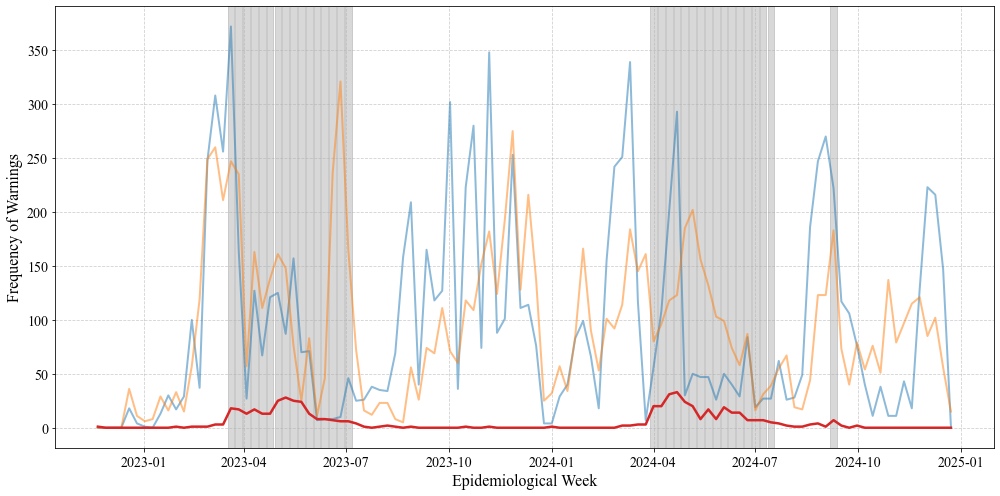

In [56]:
# Define column for AIH warnings
col_aih = 'warning_final_aih'

# Convert date column to datetime
dates = pd.to_datetime(res2['year_week_ts'])

# Identify peak warning weeks
highlight_weeks = pd.to_datetime(res2[res2[col_aih] > res2[col_aih].quantile(0.7)]['year_week_ts'])

# Create figure
plt.figure(figsize=(14, 7))  # Adjust to fit a two-column layout

# Line plots with refined styles
plt.plot(dates, res2['out_of_limits_above_phc_only'], label='Warning PHC', 
         color='#1f77b4', alpha=0.5, linewidth=2)  # Blue tone

plt.plot(dates, res2['out_of_limits_above_otc_only'], label='Warning OTC', 
         color='#ff7f0e',alpha=0.5, linewidth=2)  # Orange tone

plt.plot(dates, res2[col_aih], label='Warning Hospitalizations', 
         color='#d62728', linewidth=2.5)  # Dark red, thicker for emphasis

# Add vertical highlight bands for peak weeks
for week in highlight_weeks:
    plt.axvspan(week - pd.Timedelta(days=3), week + pd.Timedelta(days=3), 
                color='gray', alpha=0.3)  # Subtle highlight

# Format plot with Lancet-style font sizes
plt.xlabel('Epidemiological Week', fontsize=16, fontname='Times New Roman')
plt.ylabel('Frequency of Warnings', fontsize=16, fontname='Times New Roman')

plt.xticks(fontsize=14, fontname='Times New Roman')
plt.yticks(fontsize=14, fontname='Times New Roman')

# Position legend outside the plot for clarity
#plt.legend(fontsize=12, frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

plt.grid(True, linestyle='--', alpha=0.6)

# Ensure tight layout for publication
plt.tight_layout()

# Show plot
plt.show()


In [57]:
res2[col_aih].quantile(0.7)

4.299999999999997

In [58]:
res2.warning_final_aih.describe()

count    110.000000
mean       5.054545
std        7.999812
min        0.000000
25%        0.000000
50%        1.000000
75%        7.000000
max       33.000000
Name: warning_final_aih, dtype: float64

In [59]:
dta_save = res2.rename(columns={'out_of_limits_above_phc_only':'sinal_aps', 'out_of_limits_above_otc_only':'sinal_otc',
                    'warning_final_aih': 'sinal_aih'})

In [60]:
#dta_save[['year_week', 'year_week_ts', 'sinal_aps', 'sinal_aih',
#       'sinal_otc']].to_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/dado_fig3.csv')

In [61]:
test = res2.groupby(['year_week', 'year_week_ts'])[['out_of_limits_above_phc_only','out_of_limits_above_otc_only','warning_final_aih']].sum().reset_index()

In [70]:
test = test.assign(mes = test.year_week_ts.astype(str).str[5:7],
                   year =test.year_week_ts.astype(str).str[0:4])

In [71]:
test.groupby(['mes'])[['out_of_limits_above_phc_only','out_of_limits_above_otc_only','warning_final_aih']].sum().reset_index()



,mes,out_of_limits_above_phc_only,out_of_limits_above_otc_only,warning_final_aih
0,01,316,466,2
1,02,895,776,3
2,03,1814,1557,51
3,04,1030,1071,184
4,05,680,1086,168
5,06,236,932,83
6,07,331,496,37
7,08,980,295,13
8,09,1241,778,12
9,10,1015,828,1


In [73]:
test.groupby(['year','mes'])[['out_of_limits_above_phc_only','out_of_limits_above_otc_only','warning_final_aih']].sum().reset_index()


,year,mes,out_of_limits_above_phc_only,out_of_limits_above_otc_only,warning_final_aih
0,2022,11,0,0,1
1,2022,12,22,47,0
2,2023,01,61,92,1
3,2023,02,414,440,3
4,2023,03,1100,953,41
5,2023,04,342,469,56
6,2023,05,510,493,115
7,2023,06,33,614,29
8,2023,07,170,288,12
9,2023,08,470,92,4


# Counting antecipations

In [74]:
def antici_count(data_res, col_warn_s1, col_warn_s2, col_code):
    """
    Function to compute anticipated counts of warnings and missed warnings 
    across different lead times per unique region.
    
    Parameters:
    data_res (pd.DataFrame): Input DataFrame.
    col_warn_s1 (str): Column name for the primary warning signal (e.g., PHC warnings).
    col_warn_s2 (str): Column name for the secondary warning signal (e.g., AIH warnings).
    col_code (str): Column name identifying the region.

    Returns:
    pd.DataFrame: Summary DataFrame with counts of early, concurrent, and missed warnings.
    """
    
    lst_count = []

    for code in data_res[col_code].unique():
    
        dta = data_res[data_res[col_code] == code].copy()  # Use only data for the current region

        # Find sets based on PHC warnings (col_warn_s1) and AIH warnings (col_warn_s2) at different lags
        set3 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 1)].index + 3
        set2 = dta[(dta[col_warn_s1] == 1) & (dta[col_warn_s2].shift(-3) == 0) & (dta[col_warn_s2].shift(-2) == 1)].index + 2
        set1 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 1)].index + 1
        set0 = dta[(dta[col_warn_s1] == 1) & 
                   (dta[col_warn_s2] == 1) & 
                   (dta[col_warn_s2].shift(-3) == 0) & 
                   (dta[col_warn_s2].shift(-2) == 0) & 
                   (dta[col_warn_s2].shift(-1) == 0)].index
        
        # Identify True Negatives (TN)
        set_tn1 = dta[(dta[col_warn_s2] == 0) &  # AIH warning is 0
                      (dta[col_warn_s1] == 0) & 
                      (dta[col_warn_s1].shift(1).fillna(0) == 0) & 
                      (dta[col_warn_s1].shift(2).fillna(0) == 0) & 
                      (dta[col_warn_s1].shift(3).fillna(0) == 0)
                    ].index
        
        set_fp1 = dta[(dta[col_warn_s2] == 0) & 
                   ((dta[col_warn_s1] == 1) | 
                   (dta[col_warn_s1].shift(3).fillna(0) == 1) | 
                   (dta[col_warn_s1].shift(2).fillna(0) == 1) | 
                   (dta[col_warn_s1].shift(1).fillna(0) == 1))].index

        # Warnings in PHC right after an AIH warning (possibly not anticipated but concurrent)
        set1_after = dta[(dta[col_warn_s1].shift(-1) == 1) & (dta[col_warn_s2] == 1)].index
        
       

        # Compute counts of warnings at different lead times
        n3 = len(set3)
        n2 = len(set(set2) - set(set3))
        n1 = len((set(set1) - set(set3)) - set(set2))
        n0 = len(((set(set0) - set(set3)) - set(set2)) - set(set1))
        n1_after = len((((set(set1_after) - set(set3)) - set(set2)) - set(set1)) - set(set0))
        n_tn1 = len(set_tn1) 
        n_fp1 = len(set_fp1)

        # Drop all anticipated and concurrent warnings to count missed ones
        ind_drop = set(set3) | set(set2) | set(set1) | set(set0) #| set(set1_after)
        missed = dta.drop(index=ind_drop)[col_warn_s2].sum()
        
        TP = n3 + n2 + n1 + n0
        
        # outra forma de calcular o FN
        #set_FN = dta[(dta[col_warn_s2] == 1) &  
        #           (dta[col_warn_s1] == 0) & 
        #           (dta[col_warn_s1].shift(3).fillna(0) == 0) & 
        #           (dta[col_warn_s1].shift(2).fillna(0) == 0) & 
        #           (dta[col_warn_s1].shift(1).fillna(0) == 0)].index
        
        
        # Create the results dictionary for this region
        data = {
            col_code: [code],
            'n3': [n3],
            'n2': [n2],
            'n1': [n1],
            'n0': [n0],
            'n1_after': [n1_after],
            'missed': [missed],
            'TP': [TP],
            'TN1': [n_tn1], # True Negative
            'FP1': [n_fp1], # False Positive
            'FN': missed,
            'total_aih_warning': [dta[col_warn_s2].sum()]
        }

        # Append to results list
        data_output = pd.DataFrame(data)
        lst_count.append(data_output)

    # Combine all results into a single DataFrame
    df_warning_count = pd.concat(lst_count, ignore_index=True)
    
    return df_warning_count


In [75]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

### APS e AIH

In [76]:
df_warning_count = antici_count(result, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')


In [77]:
df_warning_count.to_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_aps_aih.parquet')

In [78]:
def summarize_performance(df_warning_count):
    """
    Summarizes performance metrics including Sensitivity, Specificity, PPV, F1-score, POD, and FPR.
    
    Parameters:
    df_warning_count (pd.DataFrame): Dataframe containing warning counts and classification metrics.
    
    Returns:
    pd.DataFrame: Summary table with performance metrics.
    """
    # Total AIH Warnings
    total_warnings = df_warning_count.total_aih_warning.sum()
    
    # Early Detection (1 to 3 weeks)
    early_count = df_warning_count.n3.sum() + df_warning_count.n2.sum() + df_warning_count.n1.sum()
    early_rate = round((early_count * 100) / total_warnings, 1)
    
    # Timely Detection (0 week)
    timely_count = df_warning_count.n0.sum()
    timely_rate = round((timely_count * 100) / total_warnings, 1)
    
    # Missed Warnings
    missed_count = df_warning_count.missed.sum()
    missed_rate = round((missed_count * 100) / total_warnings, 1)
    
    # Classification Metrics
    TP = df_warning_count.TP.sum()
    FN = df_warning_count.FN.sum()
    TN = df_warning_count.TN1.sum()
    FP = df_warning_count.FP1.sum()

    
    # Sensitivity (Recall)
    Sensitivity = round((TP / (TP + FN)) * 100, 1) if (TP + FN) > 0 else 0
    
    # Specificity
    Specificity = round((TN / (TN + FP)) * 100, 1) if (TN + FP) > 0 else 0
    
    # Positive Predictive Value (PPV)
    PPV = round((TP / (TP + FP)) * 100, 1) if (TP + FP) > 0 else 0
    
    # F1-score
    F1_score = round(2 * (TP / (TP + FN)) * (TP / (TP + FP)) / ((TP / (TP + FN)) + (TP / (TP + FP))), 2) if ((TP / (TP + FN)) + (TP / (TP + FP))) > 0 else 0
    
    Precision = round(((TP + TN) / (TP + TN + FP + FN) * 100), 1) if (TP + TN + FP + FN) > 0 else 0

    # Probability of Detection (POD)
    POD = round(((early_count + timely_count + df_warning_count.n1_after.sum()) / total_warnings) * 100, 1)
    
    # False Positive Rate (FPR)
    FPR = round((FP / (FP + TN)) * 100, 1) if (FP + TN) > 0 else 0
    
    # Create summary DataFrame
    summary_df = pd.DataFrame({
        "Metric": ["Total Warnings", "Early Detection (1-3 weeks)", "Timely Detection (0 weeks)", "Missed Warnings",
                   "Sensitivity ", "Specificity", "PPV",  "POD", "FPR","Precision (%)"],
        "Value": [total_warnings, f"{early_count} ({early_rate}%)", f"{timely_count} ({timely_rate}%)", f"{missed_count} ({missed_rate}%)",
                   f"{Sensitivity}%", f"{Specificity}%", f"{PPV}%", f"{POD}%", f"{FPR}%", f"{Precision}%"]
    })
    
    return summary_df



In [79]:
performance_summary = summarize_performance(df_warning_count)


In [80]:
performance_summary

,Metric,Value
0,Total Warnings,556
1,Early Detection (1-3 weeks),302 (54.3%)
2,Timely Detection (0 weeks),47 (8.5%)
3,Missed Warnings,207 (37.2%)
4,Sensitivity,62.8%
5,Specificity,52.8%
6,PPV,1.7%
7,POD,68.9%
8,FPR,47.2%
9,Precision (%),52.9%


### OTC and AIH

In [81]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')

In [82]:
df_warning_count

,co_imed,n3,n2,n1,n0,n1_after,missed,TP,TN1,FP1,FN,total_aih_warning
0,120003,0,0,0,1,1,1,1,50,58,1,2
1,120004,1,0,1,0,0,0,2,64,44,0,2
2,270002,0,0,0,1,0,0,1,48,59,0,1
3,130007,1,0,0,0,0,0,1,37,72,0,1
4,160002,2,0,0,0,0,0,2,57,51,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
398,420014,0,0,0,0,0,1,0,51,52,1,1
399,420023,0,1,0,0,0,0,1,47,53,0,1
400,350005,1,0,0,0,0,0,1,51,58,0,1
401,350039,1,0,0,0,0,0,1,46,63,0,1


In [83]:
df_warning_count.to_parquet('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Results/timing_otc_aih.parquet')

In [84]:
performance_summary = summarize_performance(df_warning_count)


In [85]:
performance_summary

,Metric,Value
0,Total Warnings,556
1,Early Detection (1-3 weeks),355 (63.8%)
2,Timely Detection (0 weeks),36 (6.5%)
3,Missed Warnings,165 (29.7%)
4,Sensitivity,70.3%
5,Specificity,48.8%
6,PPV,1.7%
7,POD,77.3%
8,FPR,51.2%
9,Precision (%),49.1%


## OTC and APS

In [86]:
df_warning_count = antici_count(result, 'out_of_limits_above_otc_only', 'out_of_limits_above_phc_only', 'co_imed')

In [87]:
performance_summary = summarize_performance(df_warning_count)


In [88]:
performance_summary

,Metric,Value
0,Total Warnings,10401
1,Early Detection (1-3 weeks),3613 (34.7%)
2,Timely Detection (0 weeks),291 (2.8%)
3,Missed Warnings,6497 (62.5%)
4,Sensitivity,37.5%
5,Specificity,52.9%
6,PPV,19.7%
7,POD,61.0%
8,FPR,47.1%
9,Precision (%),49.2%


# APS and OTC

In [89]:
df_warning_count = antici_count(result, 'out_of_limits_above_phc_only', 'out_of_limits_above_otc_only', 'co_imed')

In [90]:
performance_summary = summarize_performance(df_warning_count)


In [91]:
performance_summary

,Metric,Value
0,Total Warnings,10238
1,Early Detection (1-3 weeks),4044 (39.5%)
2,Timely Detection (0 weeks),215 (2.1%)
3,Missed Warnings,5979 (58.4%)
4,Sensitivity,41.6%
5,Specificity,57.7%
6,PPV,22.9%
7,POD,62.3%
8,FPR,42.3%
9,Precision (%),54.0%


# Study peformance by macro region and pop size

In [92]:
dta1 = df_aps[[ 'co_imed', 'Nome_imed', 'year_week', 'year_week_ts', 'out_of_limits_above_phc_only']]
dta2 = df_otc[[ 'co_imed', 'year_week', 'out_of_limits_above_otc_only']]
dta3 = df_aih[[ 'co_imed', 'year_week', 'warning_final_aih']]


result = dta1.merge(dta2, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

result = result.merge(dta3, left_on=['co_imed','year_week'], right_on=['co_imed','year_week'])

In [93]:
# Read dictionary with municipalities
df_imed_key = pd.read_csv('/Users/julianeoliveira/Documents/github/Bivariate_Anomaly_Detection_Primary_Health_Care_Drug_Selling_ILI_surveillance/Data/RELATORIO_DTB_BRASIL_MUNICIPIO.csv',sep = ';')
df_pop = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Population/table_2009_2023_etcc_eq_zero.csv')


In [94]:
df_pop = df_pop[['Cód.', 'Uf', '2022']]

df_imed_key = df_imed_key[['Nome_UF', 'UF',  'Região Geográfica Imediata',
       'Nome Região Geográfica Imediata', 
       'Município', 'Código Município Completo', 'Nome_Município']]

df_pop = df_pop.rename(columns = {'Cód.': 'co_ibge7'}) 

df_imed_key = df_imed_key.rename(columns = {'Código Município Completo': 'co_ibge7', 
                                            'Região Geográfica Imediata': 'co_imed'})

df_imed_key = df_imed_key.merge(df_pop, on='co_ibge7', how='left')

df_imed_pop = df_imed_key.groupby(['co_imed'])['2022'].sum().reset_index()

df_imed_pop = df_imed_pop.assign(pop_2022 = df_imed_pop['2022'].astype(int))
df_imed_pop = df_imed_pop[['co_imed', 'pop_2022']]


df_codes_imed = df_imed_key.groupby(['Nome_UF','UF', 'co_imed','Uf'])['2022'].sum().reset_index()



In [95]:
# Dictionary mapping Brazilian states to their regions
state_to_region = {
    "AC": "North", "AM": "North", "AP": "North", "PA": "North", "RO": "North", "RR": "North", "TO": "North",
    "AL": "Northeast", "BA": "Northeast", "CE": "Northeast", "MA": "Northeast", "PB": "Northeast",
    "PE": "Northeast", "PI": "Northeast", "RN": "Northeast", "SE": "Northeast",
    "DF": "Center-West", "GO": "Center-West", "MT": "Center-West", "MS": "Center-West",
    "ES": "Southeast", "MG": "Southeast", "RJ": "Southeast", "SP": "Southeast",
    "PR": "South", "RS": "South", "SC": "South"
}


result2 = result.merge(df_codes_imed, on='co_imed', how='left')

# Create a new column 'region' by mapping state codes to regions
result2["region"] = result2["Uf"].map(state_to_region)


## Calculate peformance by Macro region

### APS e AIH

In [96]:
# Define macro-regions
macro_regions = result2['region'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.region == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [97]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,93,North
1,Early Detection (1-3 weeks),50 (53.8%),North
2,Timely Detection (0 weeks),9 (9.7%),North
3,Missed Warnings,34 (36.6%),North
4,Sensitivity,63.4%,North
5,Specificity,50.0%,North
6,PPV,1.9%,North
7,POD,77.4%,North
8,FPR,50.0%,North
9,Precision (%),50.2%,North


In [98]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,176,Northeast
1,Early Detection (1-3 weeks),91 (51.7%),Northeast
2,Timely Detection (0 weeks),8 (4.5%),Northeast
3,Missed Warnings,77 (43.8%),Northeast
4,Sensitivity,56.2%,Northeast
5,Specificity,52.4%,Northeast
6,PPV,1.5%,Northeast
7,POD,59.7%,Northeast
8,FPR,47.6%,Northeast
9,Precision (%),52.4%,Northeast


In [99]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,73,Center-West
1,Early Detection (1-3 weeks),43 (58.9%),Center-West
2,Timely Detection (0 weeks),12 (16.4%),Center-West
3,Missed Warnings,18 (24.7%),Center-West
4,Sensitivity,75.3%,Center-West
5,Specificity,54.7%,Center-West
6,PPV,2.2%,Center-West
7,POD,80.8%,Center-West
8,FPR,45.3%,Center-West
9,Precision (%),55.0%,Center-West


In [100]:
performance_results[3]

,Metric,Value,Region
0,Total Warnings,132,Southeast
1,Early Detection (1-3 weeks),72 (54.5%),Southeast
2,Timely Detection (0 weeks),12 (9.1%),Southeast
3,Missed Warnings,48 (36.4%),Southeast
4,Sensitivity,63.6%,Southeast
5,Specificity,53.1%,Southeast
6,PPV,1.6%,Southeast
7,POD,69.7%,Southeast
8,FPR,46.9%,Southeast
9,Precision (%),53.2%,Southeast


In [101]:
performance_results[4]

,Metric,Value,Region
0,Total Warnings,82,South
1,Early Detection (1-3 weeks),46 (56.1%),South
2,Timely Detection (0 weeks),6 (7.3%),South
3,Missed Warnings,30 (36.6%),South
4,Sensitivity,63.4%,South
5,Specificity,54.2%,South
6,PPV,1.6%,South
7,POD,67.1%,South
8,FPR,45.8%,South
9,Precision (%),54.3%,South


### OTC and AIH

In [102]:
# Define macro-regions
macro_regions = result2['region'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.region == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [103]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,93,North
1,Early Detection (1-3 weeks),59 (63.4%),North
2,Timely Detection (0 weeks),6 (6.5%),North
3,Missed Warnings,28 (30.1%),North
4,Sensitivity,69.9%,North
5,Specificity,47.5%,North
6,PPV,2.0%,North
7,POD,81.7%,North
8,FPR,52.5%,North
9,Precision (%),47.8%,North


In [105]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,176,Northeast
1,Early Detection (1-3 weeks),113 (64.2%),Northeast
2,Timely Detection (0 weeks),10 (5.7%),Northeast
3,Missed Warnings,53 (30.1%),Northeast
4,Sensitivity,69.9%,Northeast
5,Specificity,49.6%,Northeast
6,PPV,1.7%,Northeast
7,POD,74.4%,Northeast
8,FPR,50.4%,Northeast
9,Precision (%),49.9%,Northeast


In [106]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,73,Center-West
1,Early Detection (1-3 weeks),48 (65.8%),Center-West
2,Timely Detection (0 weeks),5 (6.8%),Center-West
3,Missed Warnings,20 (27.4%),Center-West
4,Sensitivity,72.6%,Center-West
5,Specificity,48.0%,Center-West
6,PPV,1.9%,Center-West
7,POD,82.2%,Center-West
8,FPR,52.0%,Center-West
9,Precision (%),48.4%,Center-West


In [107]:
performance_results[3]

,Metric,Value,Region
0,Total Warnings,132,Southeast
1,Early Detection (1-3 weeks),85 (64.4%),Southeast
2,Timely Detection (0 weeks),9 (6.8%),Southeast
3,Missed Warnings,38 (28.8%),Southeast
4,Sensitivity,71.2%,Southeast
5,Specificity,48.3%,Southeast
6,PPV,1.6%,Southeast
7,POD,78.0%,Southeast
8,FPR,51.7%,Southeast
9,Precision (%),48.5%,Southeast


In [108]:
performance_results[4]

,Metric,Value,Region
0,Total Warnings,82,South
1,Early Detection (1-3 weeks),50 (61.0%),South
2,Timely Detection (0 weeks),6 (7.3%),South
3,Missed Warnings,26 (31.7%),South
4,Sensitivity,68.3%,South
5,Specificity,50.1%,South
6,PPV,1.6%,South
7,POD,73.2%,South
8,FPR,49.9%,South
9,Precision (%),50.3%,South


## Calculate peformance by population size

In [109]:
result2 = result2.rename(columns = {'2022': 'pop'})

In [110]:
bins = [0, 1.177890e+05, 3.247680e+05, float('inf')]
labels = ['Small', 'Medium', 'Large']

result2['pop_cat'] = pd.cut(result2['pop'], bins=bins, labels=labels, right=True)

small <=  1.177890e+05 
1.177890e+05 < medium <= 3.247680e+05 
large > 3.247680e+05 

In [113]:
result2.head()

,co_imed,Nome_imed,year_week,year_week_ts,out_of_limits_above_phc_only,out_of_limits_above_otc_only,warning_final_aih,Nome_UF,UF,Uf,pop,region,pop_cat
0,120003,Sena Madureira,2022-47,2022-11-21,0,0,0,Acre,12,AC,60068,North,Small
1,120003,Sena Madureira,2022-48,2022-11-28,0,0,0,Acre,12,AC,60068,North,Small
2,120003,Sena Madureira,2022-49,2022-12-05,0,0,0,Acre,12,AC,60068,North,Small
3,120003,Sena Madureira,2022-50,2022-12-12,0,0,0,Acre,12,AC,60068,North,Small
4,120003,Sena Madureira,2022-51,2022-12-19,0,0,0,Acre,12,AC,60068,North,Small


### APS e AIH

In [114]:
# Define macro-regions
macro_regions = result2['pop_cat'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.pop_cat == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_phc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [115]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,153,Small
1,Early Detection (1-3 weeks),83 (54.2%),Small
2,Timely Detection (0 weeks),10 (6.5%),Small
3,Missed Warnings,60 (39.2%),Small
4,Sensitivity,60.8%,Small
5,Specificity,51.4%,Small
6,PPV,1.6%,Small
7,POD,68.0%,Small
8,FPR,48.6%,Small
9,Precision (%),51.5%,Small


In [116]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,290,Medium
1,Early Detection (1-3 weeks),162 (55.9%),Medium
2,Timely Detection (0 weeks),25 (8.6%),Medium
3,Missed Warnings,103 (35.5%),Medium
4,Sensitivity,64.5%,Medium
5,Specificity,53.3%,Medium
6,PPV,1.8%,Medium
7,POD,70.7%,Medium
8,FPR,46.7%,Medium
9,Precision (%),53.5%,Medium


In [117]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,113,Large
1,Early Detection (1-3 weeks),57 (50.4%),Large
2,Timely Detection (0 weeks),12 (10.6%),Large
3,Missed Warnings,44 (38.9%),Large
4,Sensitivity,61.1%,Large
5,Specificity,53.2%,Large
6,PPV,1.5%,Large
7,POD,65.5%,Large
8,FPR,46.8%,Large
9,Precision (%),53.2%,Large


### OTC and AIH

In [118]:
# Define macro-regions
macro_regions = result2['pop_cat'].unique()

# Initialize an empty list to store results
performance_results = []

# Iterate through each region and compute performance
for region in macro_regions:
    dta_reg = result2[result2.pop_cat == region]

    df_warning_count = antici_count(dta_reg, 'out_of_limits_above_otc_only', 'warning_final_aih', 'co_imed')
    
    performance_summary = summarize_performance(df_warning_count)
    
    performance_summary['Region'] = region 
    
    performance_results.append(performance_summary)


In [119]:
performance_results[0]

,Metric,Value,Region
0,Total Warnings,153,Small
1,Early Detection (1-3 weeks),95 (62.1%),Small
2,Timely Detection (0 weeks),11 (7.2%),Small
3,Missed Warnings,47 (30.7%),Small
4,Sensitivity,69.3%,Small
5,Specificity,47.7%,Small
6,PPV,1.7%,Small
7,POD,76.5%,Small
8,FPR,52.3%,Small
9,Precision (%),48.0%,Small


In [120]:
performance_results[1]

,Metric,Value,Region
0,Total Warnings,290,Medium
1,Early Detection (1-3 weeks),190 (65.5%),Medium
2,Timely Detection (0 weeks),20 (6.9%),Medium
3,Missed Warnings,80 (27.6%),Medium
4,Sensitivity,72.4%,Medium
5,Specificity,48.8%,Medium
6,PPV,1.8%,Medium
7,POD,79.3%,Medium
8,FPR,51.2%,Medium
9,Precision (%),49.1%,Medium


In [121]:
performance_results[2]

,Metric,Value,Region
0,Total Warnings,113,Large
1,Early Detection (1-3 weeks),70 (61.9%),Large
2,Timely Detection (0 weeks),5 (4.4%),Large
3,Missed Warnings,38 (33.6%),Large
4,Sensitivity,66.4%,Large
5,Specificity,50.3%,Large
6,PPV,1.5%,Large
7,POD,73.5%,Large
8,FPR,49.7%,Large
9,Precision (%),50.4%,Large
